[View in Colaboratory](https://colab.research.google.com/github/Santosh-Gupta/Research2Vec/blob/master/Research2VecPublicPlayGround.ipynb)

↓↓↓  Stuff you don't have to touch (unless you want to) just run it ↓↓↓ This will download the Tensorflow Model (2 GB) and necessary Python dictionaries into your Colab environment. 

In [2]:
#SECTION 1

import re
from collections import Counter
import time
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pyplot
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from urllib.request import urlretrieve
from os.path import isfile, isdir
import keras
import requests
import pickle
!pip install https://github.com/Phlya/adjustText/archive/master.zip
import importlib
import adjustText
importlib.reload(adjustText)
from adjustText import adjust_text

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                
download_file_from_google_drive('15_inqIvXBnaC5mI_GPxLnV8Va8hxIqAM', 'model.zip') #using cbow 2 inputs

if not os.path.exists('MODEL'):
    os.makedirs('MODEL')

# UNZIP ZIP
print("Uncompressing zip file")
zip_ref = zipfile.ZipFile('model.zip', 'r')
zip_ref.extractall('MODEL/')
zip_ref.close()

print( os.getcwd() )
print( os.listdir('./MODEL') )

download_file_from_google_drive('1mdF0JfrzbOxeHD26JaUW8KEfIdMEHzQG', 'titleDict.pickle')

with open('titleDict.pickle', 'rb') as handle:
    titleDict = pickle.load(handle)
    
download_file_from_google_drive('12fiWctMsUJbmq0JaT3H8Zh23GdtxZThh', 'idDict.pickle')

with open('idDict.pickle', 'rb') as handle:
    idDict = pickle.load(handle)
    
download_file_from_google_drive('1xOF1qw6B0Sl63ROovlBDU4DbfaJbplxY', 'linkDict.pickle')

with open('linkDict.pickle', 'rb') as handle:
    linkDict = pickle.load(handle)
    
with tf.Session() as sess:
  saver = tf.train.import_meta_graph('./MODEL/Research2VecEmbedSize80.ckpt.meta')
  saver.restore(sess, './MODEL/Research2VecEmbedSize80.ckpt' )

  embeddings = tf.get_default_graph().get_tensor_by_name('embeddings:0') 
  softmax_weights = tf.get_default_graph().get_tensor_by_name('softmax_weights:0') 
  
  normSM = tf.sqrt(tf.reduce_sum(tf.square(softmax_weights), 1, keepdims=True))
  normalized_embeddingsSM = softmax_weights / normSM
  
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  
  final_embeddings = normalized_embeddings.eval()
  final_embeddingsSM = normalized_embeddingsSM.eval()
  



     \ 3.4MB 69.5MB/s
  Running setup.py bdist_wheel for adjustText ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-g0xhx1sm/wheels/7a/56/aa/ee86b18565ad149ba3a5470b55bbc5081701fd0b57141ed055
Successfully built adjustText
Uncompressing zip file
/content
['Research2VecEmbedSize80.ckpt.index', 'checkpoint', 'Research2VecEmbedSize80.ckpt.meta', 'Research2VecEmbedSize80.ckpt.data-00000-of-00001']
INFO:tensorflow:Restoring parameters from ./MODEL/Research2VecEmbedSize80.ckpt


^^^ Stuff you don't have to touch (unless you want to) just run it ^^^

In [9]:
#Section 2

#Use https://www.semanticscholar.org to first find papers you want to analyze, then 'titlePhrase' to find the paper in this recommender.  

titlePhrase = 'lstm recurrent networks'  
lines = []
for i in titleDict:
  if type(titleDict[i]) is str:
    if str.lower(titlePhrase) in str.lower(titleDict[i]) :
        lines.append(i)
print("Number of results ", len(lines))
for j in lines:
  print("EMBED ID:", j, "| TITLE:", titleDict[j], "| LINK:",  linkDict[j] )
  

Number of results  3
EMBED ID: 140393 | TITLE: Finding temporal structure in music: blues improvisation with LSTM recurrent networks | LINK: https://semanticscholar.org/paper/60c36d469c48541ec06f92cf982de0f7e12093cf
EMBED ID: 344093 | TITLE: Learning Precise Timing with LSTM Recurrent Networks | LINK: https://semanticscholar.org/paper/047655e733a9eed9a500afd916efa566915b9110
EMBED ID: 1418824 | TITLE: Incremental sentence compression using LSTM recurrent networks | LINK: https://semanticscholar.org/paper/4720f79749d740e18bed4ade8d6b6b742c9dc112


In [10]:
#Section 3

idString = 'd3bbd57899d938e8c4bcafbbda10ceb59638e4db'  
lines = []
for i in idDict:
  if type(idDict[i]) is str:
    if idString in str.lower(idDict[i]) :
        lines.append(i)
for j in lines:
  print(idString)
  print("EMBED ID:", j, "| TITLE:", titleDict[j], "| LINK:",  linkDict[j] )

d3bbd57899d938e8c4bcafbbda10ceb59638e4db
EMBED ID: 459313 | TITLE: Skip-Thought Vectors | LINK: https://semanticscholar.org/paper/d3bbd57899d938e8c4bcafbbda10ceb59638e4db


In [12]:
#Section 4

NumberOfPapers = 300  #Number of most similar papers to view and analyze in TSNE

#Set the embedID's of the paper(s) you want analyzed. 
paper1EmbedID = 459313  #TITLE: Skip-Thought Vectors | LINK: https://semanticscholar.org/paper/d3bbd57899d938e8c4bcafbbda10ceb59638e4db
paper2EmbedID = 431721 # TITLE: Convolutional Neural Networks for Sentence Classification | LINK: https://semanticscholar.org/paper/398dee13b3aaaefdf14c78cc1e00dcf265795fd3
paper3EmbedID = 244279  #TITLE: Distributed Representations of Sentences and Documents | LINK: https://semanticscholar.org/paper/1510cf4b8abea80b9f352325ca4c132887de21a0
paper4EmbedID = 1418824 # TITLE: Incremental sentence compression using LSTM recurrent networks | LINK: https://semanticscholar.org/paper/4720f79749d740e18bed4ade8d6b6b742c9dc112

# ↓↓↓ You can adjust this to use any number of combined papers ↓↓↓

paper1 = np.take(final_embeddings, paper1EmbedID , axis=0)   
paper2 = np.take(final_embeddings, paper2EmbedID , axis=0) 
paper3 = np.take(final_embeddings, paper3EmbedID , axis=0)   
paper4 = np.take(final_embeddings, paper4EmbedID , axis=0) 

extracted_v = paper1 + paper2 + paper3 + paper4  #Don't need to average since vectors are normalized 

# ^^^ You can adjust this to use any number of combined papers ^^^

dotprods_v = np.matmul(extracted_v, np.transpose(final_embeddings))

nearestPapers = (-dotprods_v).argsort()[0:NumberOfPapers]

for k in range(0, 300):
  print("EMBED ID:", nearestPapers[k], "| TITLE:", titleDict[nearestPapers[k]], "| LINK:",  linkDict[nearestPapers[k]] )

EMBED ID: 431721 | TITLE: Convolutional Neural Networks for Sentence Classification | LINK: https://semanticscholar.org/paper/398dee13b3aaaefdf14c78cc1e00dcf265795fd3
EMBED ID: 244279 | TITLE: Distributed Representations of Sentences and Documents | LINK: https://semanticscholar.org/paper/1510cf4b8abea80b9f352325ca4c132887de21a0
EMBED ID: 459313 | TITLE: Skip-Thought Vectors | LINK: https://semanticscholar.org/paper/d3bbd57899d938e8c4bcafbbda10ceb59638e4db
EMBED ID: 901754 | TITLE: A Convolutional Neural Network for Modelling Sentences | LINK: https://semanticscholar.org/paper/03ff3f8f4d5a700fbe8f3a3e63a39523c29bb60f
EMBED ID: 343263 | TITLE: Improved Semantic Representations From Tree-Structured Long Short-Term Memory Networks | LINK: https://semanticscholar.org/paper/4e88de2930a4435f737c3996287a90ff87b95c59
EMBED ID: 93290 | TITLE: Natural Language Processing (Almost) from Scratch | LINK: https://semanticscholar.org/paper/2538e3eb24d26f31482c479d95d2e26c0e79b990
EMBED ID: 77688 | TIT

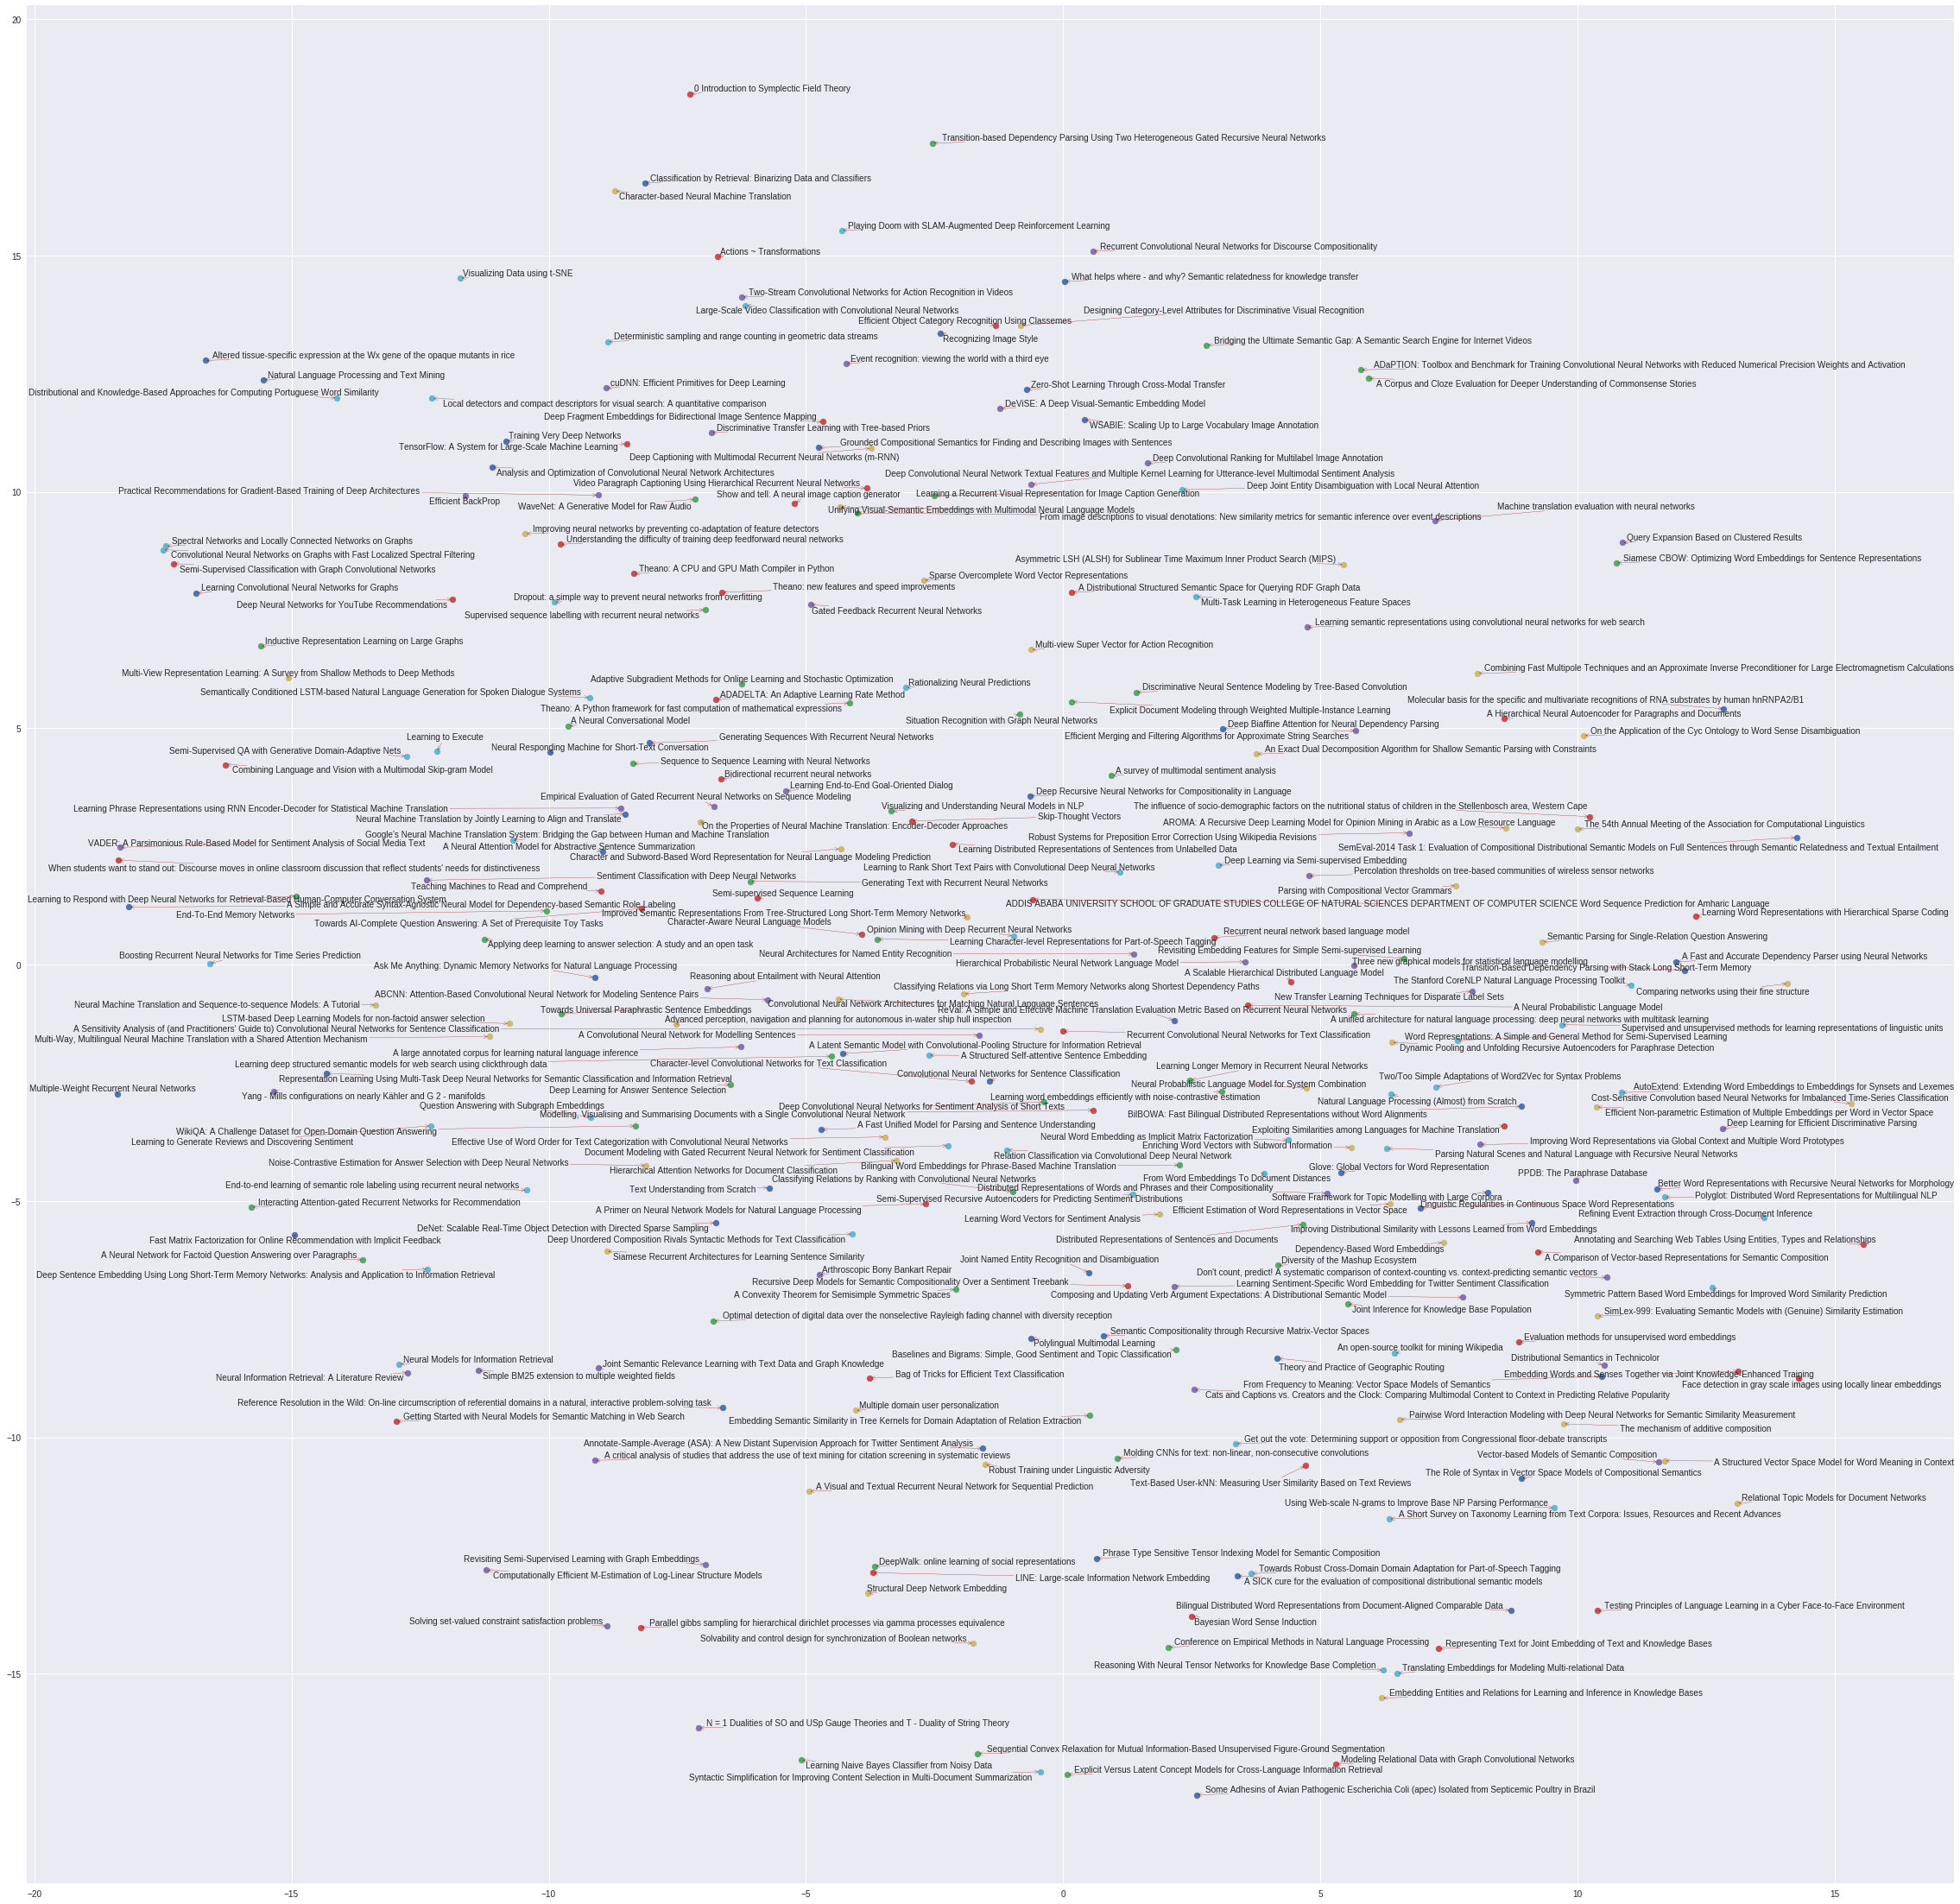

In [13]:
#Section 5

#Run this for a T-SNE map for the returned similar papers. Will take 15-18 minutes

for_TSNE = np.take(final_embeddings, nearestPapers, axis=0) 

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(for_TSNE)

texts = []

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pyplot.figure(figsize=(40, 40))  # in inches

  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pyplot.scatter(x, y)
    texts.append(pyplot.text(x, y, label))
  
  adjust_text(texts , arrowprops=dict(arrowstyle='->', color='#8f1402' ) ) 
  
  pyplot.show()


papers = [titleDict[i] for i in nearestPapers]
plot(two_d_embeddings, papers)
